In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision.utils import make_grid
# import torchvision.utils as vutils
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import math
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

In [2]:
df = pd.read_csv("train.csv")

In [3]:
len(df)

42000

In [4]:
# 1 represents real, 0 fake
df['label'] = 1

In [5]:
X_discriminator = df.drop('label', axis=1)
y_discriminator = torch.tensor(df['label'].values, dtype=torch.float32)

In [6]:
pixel_columns = df.shape[1] - 1  # subtracting 1 for the label column

image_side_length = int(pixel_columns**0.5)
print(f"Each image is {image_side_length}x{image_side_length} pixels.")

Each image is 28x28 pixels.


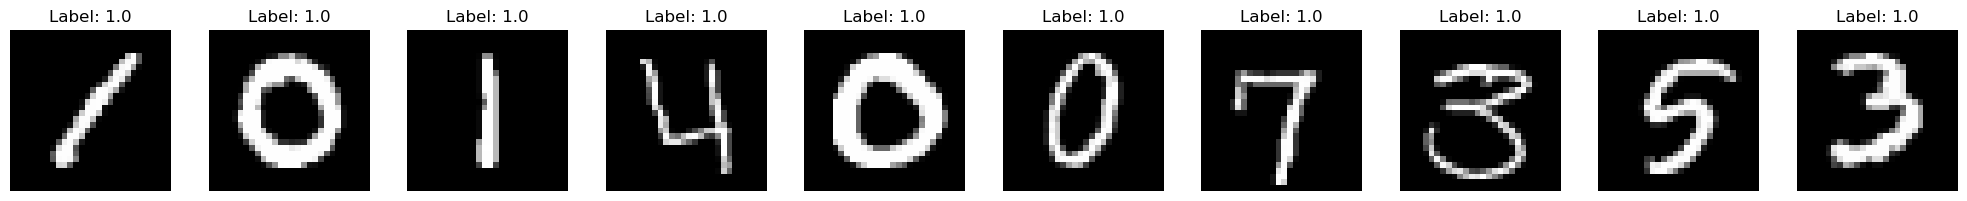

In [7]:
fig, axes = plt.subplots(1, 10, figsize=(20, 2))  
for i, ax in enumerate(axes):
    # Reshape each row into 28x28 array and plot
    img = X_discriminator.iloc[i].to_numpy().reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {y_discriminator[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [8]:
X_discriminator = X_discriminator.values.reshape(-1, 1, 28, 28)
X_discriminator = (torch.tensor(X_discriminator).float() / 255.0) * 2 - 1

In [9]:
dataset_discriminator = TensorDataset(X_discriminator, y_discriminator)
loader_discriminator = DataLoader(dataset_discriminator, batch_size=64, shuffle=True)

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(in_features=128*7*7, out_features=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.conv5(x)))

        x = F.relu(self.conv6(x))
        x = x.view(-1, 128*7*7)
        x = self.dropout(x)
        x = self.fc(x)
        return torch.sigmoid(x)

In [11]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.fc = nn.Linear(in_features=noise_dim, out_features=noise_dim) # (1, 49) -> (1, 7, 7)
        self.convT1 = nn.ConvTranspose2d(in_channels=1, out_channels=128, kernel_size=4, stride=1)  # (1, 7, 7) -> (1, 10, 10)
        self.bn1 = nn.BatchNorm2d(num_features=128)
        self.convT2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2) # (1, 10, 10) -> (1, 22, 22)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.convT3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1) # (1, 22, 22) -> (1, 24, 24)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.convT4 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1) # (1, 24, 24) -> (1, 26, 26)
        self.bn4 = nn.BatchNorm2d(num_features=16)
        # self.dropout = nn.Dropout(0.3)
        self.convT5 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=1) # (1, 26, 26) -> (1, 28, 28)

    def forward(self, x):
        x = F.leaky_relu(self.fc(x))
        x = x.view(-1, 1, int(math.sqrt(noise_dim)), int(math.sqrt(noise_dim)))
        x = F.relu(self.bn1(self.convT1(x)))
        x = F.relu(self.bn2(self.convT2(x)))
        x = F.relu(self.bn3(self.convT3(x)))
        x = F.relu(self.bn4(self.convT4(x)))
        # x = self.dropout(x)
        x = torch.tanh(self.convT5(x))
        return x

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

noise_dim = 49
generator = Generator(noise_dim=noise_dim).to(device)
discriminator = Discriminator().to(device)

optim_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
scheduler_G = StepLR(optimizer=optim_G, step_size=20, gamma=1.2)
# scheduler_D = StepLR(optimizer=optim_D, step_size=5, gamma=0.4)

100%|██████████████████████████████████████████████████████| 657/657 [00:56<00:00, 11.55it/s, loss_D=1.28, loss_G=1.15]


Epoch [1/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [1/100] - Average D loss: 1.2710, Average G loss: 0.8444


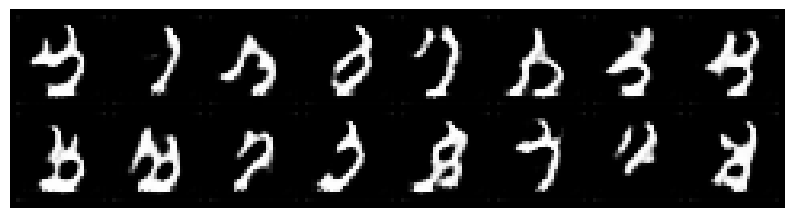

100%|██████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.29it/s, loss_D=1.11, loss_G=1.53]


Epoch [2/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [2/100] - Average D loss: 1.1945, Average G loss: 0.9700


100%|███████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.27it/s, loss_D=1.03, loss_G=0.9]


Epoch [3/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [3/100] - Average D loss: 1.1513, Average G loss: 1.0386


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.25it/s, loss_D=1.09, loss_G=0.945]

Epoch [4/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [4/100] - Average D loss: 1.0874, Average G loss: 1.0980


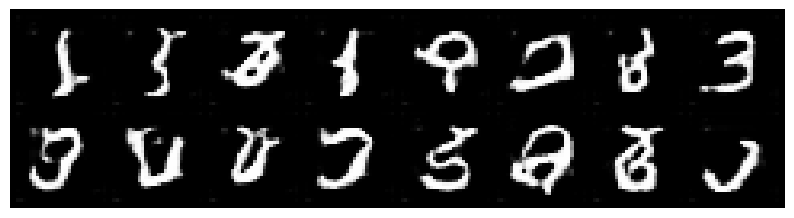

100%|█████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.27it/s, loss_D=0.951, loss_G=1.06]


Epoch [5/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [5/100] - Average D loss: 1.0287, Average G loss: 1.1777


100%|██████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.24it/s, loss_D=1.08, loss_G=1.33]


Epoch [6/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [6/100] - Average D loss: 0.9905, Average G loss: 1.2596


100%|██████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.27it/s, loss_D=1.09, loss_G=1.06]


Epoch [7/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [7/100] - Average D loss: 0.9590, Average G loss: 1.3194


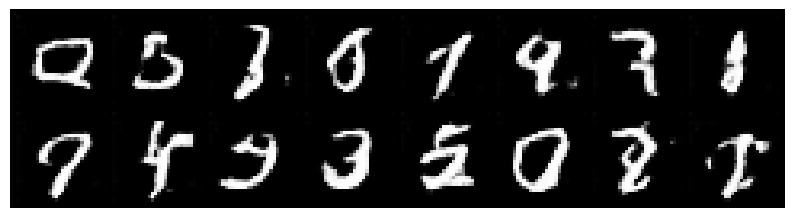

100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.25it/s, loss_D=1.08, loss_G=0.951]


Epoch [8/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [8/100] - Average D loss: 0.9080, Average G loss: 1.4258


100%|█████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.27it/s, loss_D=0.838, loss_G=1.18]


Epoch [9/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [9/100] - Average D loss: 0.8716, Average G loss: 1.5253


100%|█████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.25it/s, loss_D=0.962, loss_G=1.26]

Epoch [10/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [10/100] - Average D loss: 0.8382, Average G loss: 1.5938


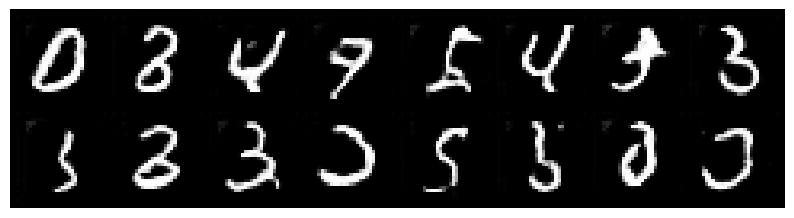

100%|██████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.25it/s, loss_D=1.05, loss_G=1.38]


Epoch [11/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [11/100] - Average D loss: 0.8030, Average G loss: 1.6911


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.22it/s, loss_D=0.582, loss_G=2.33]


Epoch [12/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [12/100] - Average D loss: 0.7838, Average G loss: 1.7564


100%|██████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.27it/s, loss_D=0.55, loss_G=1.24]

Epoch [13/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [13/100] - Average D loss: 0.7666, Average G loss: 1.8138


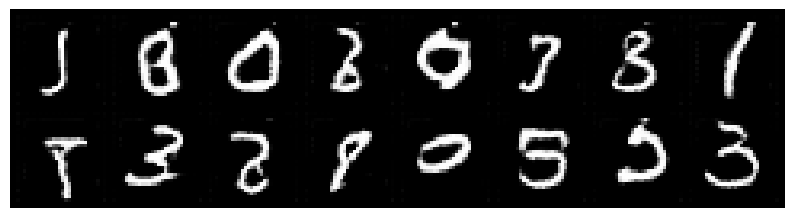

100%|██████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.24it/s, loss_D=1.02, loss_G=1.66]


Epoch [14/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [14/100] - Average D loss: 0.7508, Average G loss: 1.8627


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.23it/s, loss_D=0.921, loss_G=3.03]


Epoch [15/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [15/100] - Average D loss: 0.7210, Average G loss: 1.9334


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.23it/s, loss_D=0.981, loss_G=2.41]


Epoch [16/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [16/100] - Average D loss: 0.7150, Average G loss: 1.9704


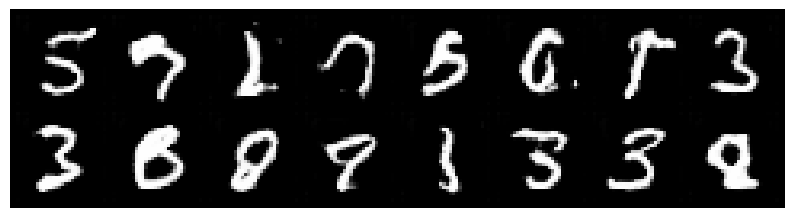

100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.25it/s, loss_D=0.384, loss_G=2.63]


Epoch [17/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [17/100] - Average D loss: 0.7067, Average G loss: 1.9974


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.23it/s, loss_D=0.614, loss_G=2.25]


Epoch [18/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [18/100] - Average D loss: 0.6860, Average G loss: 2.0433


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.23it/s, loss_D=0.721, loss_G=2.03]

Epoch [19/100] - LR G: 0.0002000, LR D: 0.0002000
Epoch [19/100] - Average D loss: 0.6785, Average G loss: 2.0789


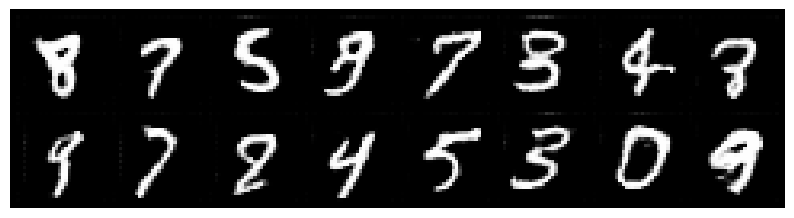

100%|███████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.23it/s, loss_D=1.1, loss_G=1.77]


Epoch [20/100] - LR G: 0.0002400, LR D: 0.0002000
Epoch [20/100] - Average D loss: 0.6813, Average G loss: 2.0761


100%|██████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.22it/s, loss_D=0.613, loss_G=1.7]


Epoch [21/100] - LR G: 0.0002400, LR D: 0.0002000
Epoch [21/100] - Average D loss: 0.6689, Average G loss: 2.1392


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.21it/s, loss_D=0.656, loss_G=2.98]

Epoch [22/100] - LR G: 0.0002400, LR D: 0.0002000
Epoch [22/100] - Average D loss: 0.6600, Average G loss: 2.1391


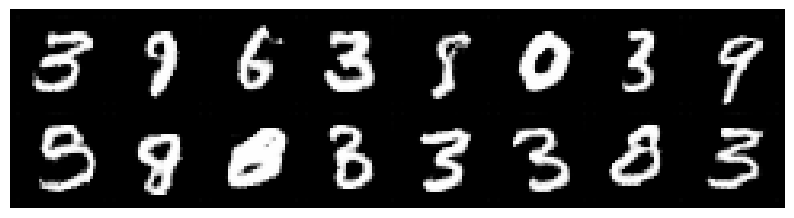

100%|█████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.28it/s, loss_D=0.699, loss_G=2.82]


Epoch [23/100] - LR G: 0.0002400, LR D: 0.0002000
Epoch [23/100] - Average D loss: 0.6608, Average G loss: 2.1453


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.24it/s, loss_D=0.855, loss_G=1.69]


Epoch [24/100] - LR G: 0.0002400, LR D: 0.0002000
Epoch [24/100] - Average D loss: 0.6622, Average G loss: 2.1376


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.23it/s, loss_D=0.497, loss_G=1.86]

Epoch [25/100] - LR G: 0.0002400, LR D: 0.0002000
Epoch [25/100] - Average D loss: 0.6565, Average G loss: 2.1355


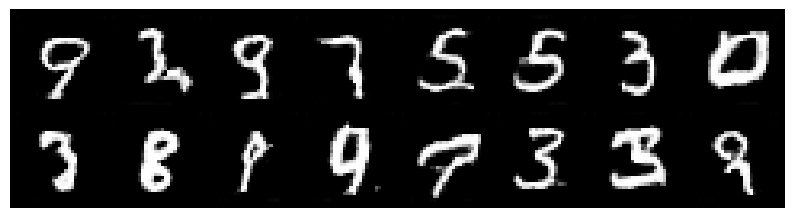

100%|██████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.26it/s, loss_D=1.01, loss_G=2.86]


Epoch [26/100] - LR G: 0.0002400, LR D: 0.0002000
Epoch [26/100] - Average D loss: 0.6620, Average G loss: 2.1300


100%|███████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.26it/s, loss_D=0.6, loss_G=1.39]


Epoch [27/100] - LR G: 0.0002400, LR D: 0.0002000
Epoch [27/100] - Average D loss: 0.6573, Average G loss: 2.1375


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.23it/s, loss_D=0.577, loss_G=2.43]

Epoch [28/100] - LR G: 0.0002400, LR D: 0.0002000
Epoch [28/100] - Average D loss: 0.6558, Average G loss: 2.1378


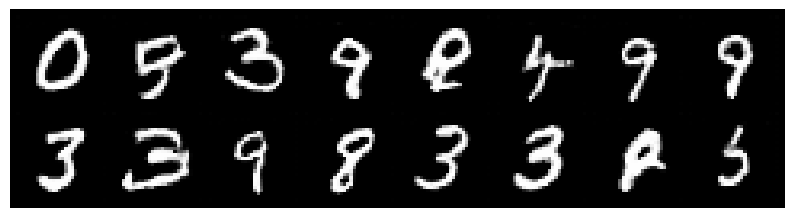

100%|█████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.29it/s, loss_D=0.525, loss_G=3.27]


Epoch [29/100] - LR G: 0.0002400, LR D: 0.0002000
Epoch [29/100] - Average D loss: 0.6605, Average G loss: 2.1190


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.24it/s, loss_D=0.616, loss_G=2.72]


Epoch [30/100] - LR G: 0.0002400, LR D: 0.0002000
Epoch [30/100] - Average D loss: 0.6492, Average G loss: 2.1532


100%|██████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.27it/s, loss_D=0.419, loss_G=2.7]

Epoch [31/100] - LR G: 0.0002400, LR D: 0.0002000
Epoch [31/100] - Average D loss: 0.6501, Average G loss: 2.1512


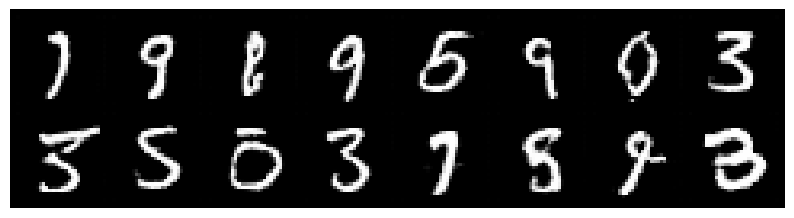

100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.22it/s, loss_D=0.534, loss_G=2.68]


Epoch [32/100] - LR G: 0.0002400, LR D: 0.0002000
Epoch [32/100] - Average D loss: 0.6528, Average G loss: 2.1290


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.25it/s, loss_D=0.895, loss_G=2.57]


Epoch [33/100] - LR G: 0.0002400, LR D: 0.0002000
Epoch [33/100] - Average D loss: 0.6518, Average G loss: 2.1312


100%|█████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.26it/s, loss_D=0.618, loss_G=2.16]

Epoch [34/100] - LR G: 0.0002400, LR D: 0.0002000
Epoch [34/100] - Average D loss: 0.6424, Average G loss: 2.1603


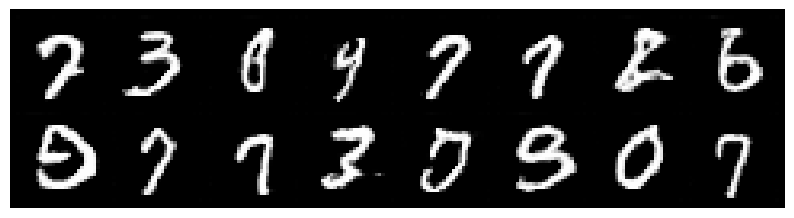

100%|█████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.27it/s, loss_D=0.443, loss_G=2.86]


Epoch [35/100] - LR G: 0.0002400, LR D: 0.0002000
Epoch [35/100] - Average D loss: 0.6519, Average G loss: 2.1428


100%|██████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.26it/s, loss_D=0.758, loss_G=2.5]


Epoch [36/100] - LR G: 0.0002400, LR D: 0.0002000
Epoch [36/100] - Average D loss: 0.6490, Average G loss: 2.1493


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.23it/s, loss_D=0.534, loss_G=1.73]


Epoch [37/100] - LR G: 0.0002400, LR D: 0.0002000
Epoch [37/100] - Average D loss: 0.6448, Average G loss: 2.1473


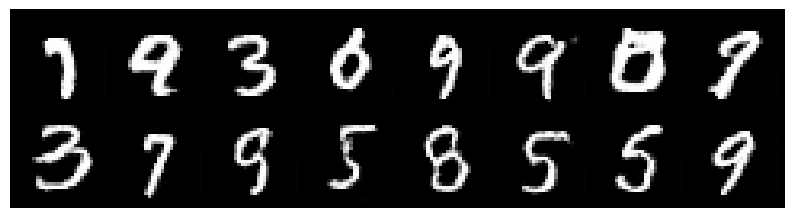

100%|██████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.27it/s, loss_D=0.66, loss_G=1.74]


Epoch [38/100] - LR G: 0.0002400, LR D: 0.0002000
Epoch [38/100] - Average D loss: 0.6333, Average G loss: 2.1716


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.25it/s, loss_D=0.781, loss_G=2.86]


Epoch [39/100] - LR G: 0.0002400, LR D: 0.0002000
Epoch [39/100] - Average D loss: 0.6429, Average G loss: 2.1523


100%|█████████████████████████████████████████████████████| 657/657 [01:11<00:00,  9.25it/s, loss_D=0.836, loss_G=2.64]


Epoch [40/100] - LR G: 0.0002880, LR D: 0.0002000
Epoch [40/100] - Average D loss: 0.6456, Average G loss: 2.1488


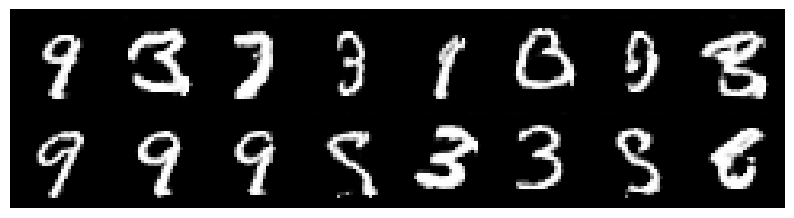

100%|█████████████████████████████████████████████████████| 657/657 [01:22<00:00,  7.98it/s, loss_D=0.544, loss_G=2.32]


Epoch [41/100] - LR G: 0.0002880, LR D: 0.0002000
Epoch [41/100] - Average D loss: 0.6388, Average G loss: 2.1720


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.464, loss_G=2.78]


Epoch [42/100] - LR G: 0.0002880, LR D: 0.0002000
Epoch [42/100] - Average D loss: 0.6356, Average G loss: 2.1834


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.95it/s, loss_D=0.604, loss_G=2.82]

Epoch [43/100] - LR G: 0.0002880, LR D: 0.0002000
Epoch [43/100] - Average D loss: 0.6313, Average G loss: 2.2018


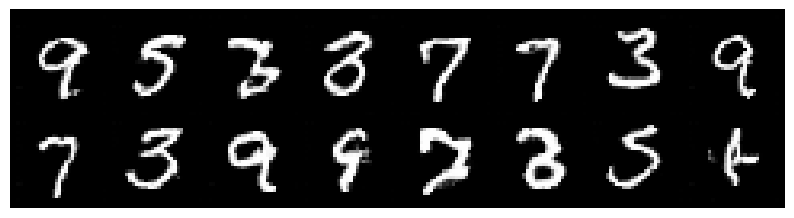

100%|████████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.92it/s, loss_D=0.573, loss_G=2]


Epoch [44/100] - LR G: 0.0002880, LR D: 0.0002000
Epoch [44/100] - Average D loss: 0.6371, Average G loss: 2.1742


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.711, loss_G=1.66]


Epoch [45/100] - LR G: 0.0002880, LR D: 0.0002000
Epoch [45/100] - Average D loss: 0.6434, Average G loss: 2.1553


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.93it/s, loss_D=0.846, loss_G=1.23]

Epoch [46/100] - LR G: 0.0002880, LR D: 0.0002000
Epoch [46/100] - Average D loss: 0.6465, Average G loss: 2.1421


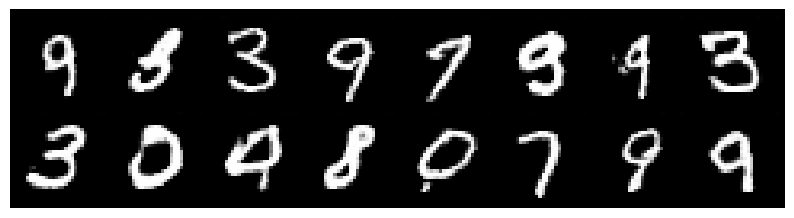

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.92it/s, loss_D=0.603, loss_G=2.64]


Epoch [47/100] - LR G: 0.0002880, LR D: 0.0002000
Epoch [47/100] - Average D loss: 0.6393, Average G loss: 2.1640


100%|██████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=1.01, loss_G=1.71]


Epoch [48/100] - LR G: 0.0002880, LR D: 0.0002000
Epoch [48/100] - Average D loss: 0.6490, Average G loss: 2.1283


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.93it/s, loss_D=0.604, loss_G=2.28]

Epoch [49/100] - LR G: 0.0002880, LR D: 0.0002000
Epoch [49/100] - Average D loss: 0.6510, Average G loss: 2.1249


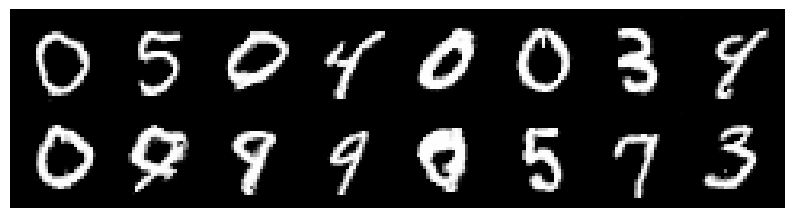

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.92it/s, loss_D=0.832, loss_G=1.93]


Epoch [50/100] - LR G: 0.0002880, LR D: 0.0002000
Epoch [50/100] - Average D loss: 0.6471, Average G loss: 2.1507


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.914, loss_G=1.49]


Epoch [51/100] - LR G: 0.0002880, LR D: 0.0002000
Epoch [51/100] - Average D loss: 0.6512, Average G loss: 2.1250


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.93it/s, loss_D=0.953, loss_G=2.17]

Epoch [52/100] - LR G: 0.0002880, LR D: 0.0002000
Epoch [52/100] - Average D loss: 0.6445, Average G loss: 2.1532


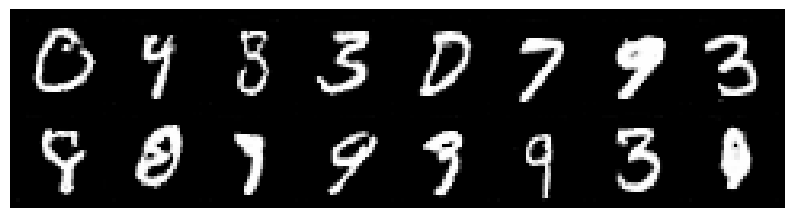

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.95it/s, loss_D=0.865, loss_G=3.75]


Epoch [53/100] - LR G: 0.0002880, LR D: 0.0002000
Epoch [53/100] - Average D loss: 0.6500, Average G loss: 2.1254


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.93it/s, loss_D=0.595, loss_G=2.16]


Epoch [54/100] - LR G: 0.0002880, LR D: 0.0002000
Epoch [54/100] - Average D loss: 0.6441, Average G loss: 2.1510


100%|██████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.95it/s, loss_D=0.429, loss_G=2.5]

Epoch [55/100] - LR G: 0.0002880, LR D: 0.0002000
Epoch [55/100] - Average D loss: 0.6387, Average G loss: 2.1433


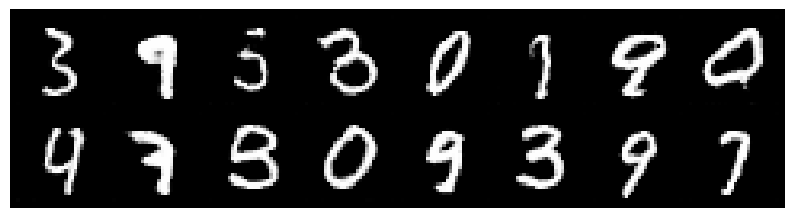

100%|██████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.95it/s, loss_D=0.473, loss_G=1.9]


Epoch [56/100] - LR G: 0.0002880, LR D: 0.0002000
Epoch [56/100] - Average D loss: 0.6436, Average G loss: 2.1302


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.96it/s, loss_D=0.632, loss_G=1.75]


Epoch [57/100] - LR G: 0.0002880, LR D: 0.0002000
Epoch [57/100] - Average D loss: 0.6322, Average G loss: 2.1749


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.93it/s, loss_D=0.271, loss_G=3.31]

Epoch [58/100] - LR G: 0.0002880, LR D: 0.0002000
Epoch [58/100] - Average D loss: 0.6336, Average G loss: 2.1793


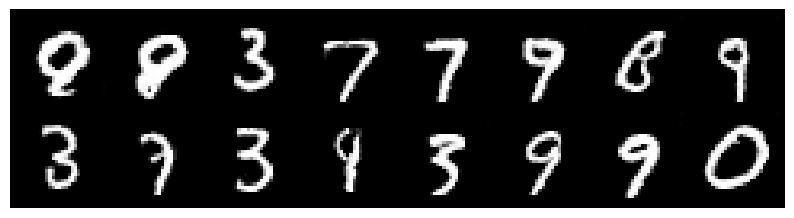

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.95it/s, loss_D=0.516, loss_G=2.72]


Epoch [59/100] - LR G: 0.0002880, LR D: 0.0002000
Epoch [59/100] - Average D loss: 0.6302, Average G loss: 2.1859


100%|██████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.95it/s, loss_D=0.75, loss_G=1.72]


Epoch [60/100] - LR G: 0.0003456, LR D: 0.0002000
Epoch [60/100] - Average D loss: 0.6302, Average G loss: 2.1807


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.93it/s, loss_D=0.489, loss_G=2.44]

Epoch [61/100] - LR G: 0.0003456, LR D: 0.0002000
Epoch [61/100] - Average D loss: 0.6110, Average G loss: 2.2476


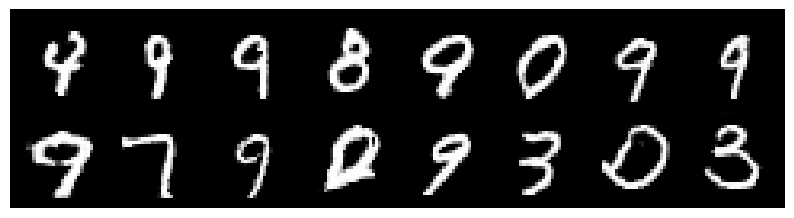

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.97it/s, loss_D=0.907, loss_G=2.09]


Epoch [62/100] - LR G: 0.0003456, LR D: 0.0002000
Epoch [62/100] - Average D loss: 0.6104, Average G loss: 2.2306


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.559, loss_G=2.32]


Epoch [63/100] - LR G: 0.0003456, LR D: 0.0002000
Epoch [63/100] - Average D loss: 0.6129, Average G loss: 2.2392


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.95it/s, loss_D=0.727, loss_G=2.48]

Epoch [64/100] - LR G: 0.0003456, LR D: 0.0002000
Epoch [64/100] - Average D loss: 0.6032, Average G loss: 2.2580


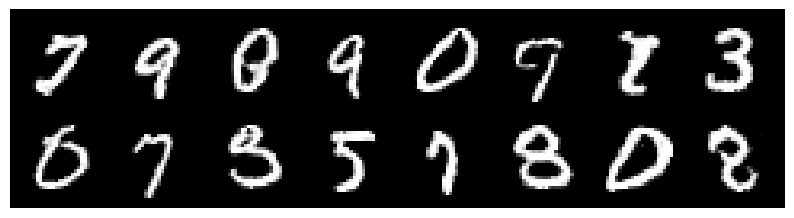

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.95it/s, loss_D=0.313, loss_G=3.09]


Epoch [65/100] - LR G: 0.0003456, LR D: 0.0002000
Epoch [65/100] - Average D loss: 0.5973, Average G loss: 2.2795


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.97it/s, loss_D=0.587, loss_G=1.79]


Epoch [66/100] - LR G: 0.0003456, LR D: 0.0002000
Epoch [66/100] - Average D loss: 0.5968, Average G loss: 2.2838


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.96it/s, loss_D=0.651, loss_G=2.57]

Epoch [67/100] - LR G: 0.0003456, LR D: 0.0002000
Epoch [67/100] - Average D loss: 0.6089, Average G loss: 2.2315


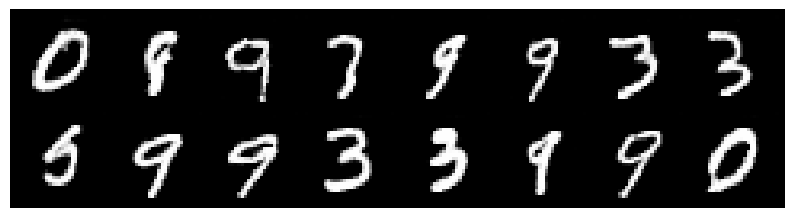

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.398, loss_G=2.16]


Epoch [68/100] - LR G: 0.0003456, LR D: 0.0002000
Epoch [68/100] - Average D loss: 0.5998, Average G loss: 2.2484


100%|███████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.97it/s, loss_D=0.6, loss_G=2.55]


Epoch [69/100] - LR G: 0.0003456, LR D: 0.0002000
Epoch [69/100] - Average D loss: 0.6026, Average G loss: 2.2516


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.97it/s, loss_D=0.667, loss_G=2.44]

Epoch [70/100] - LR G: 0.0003456, LR D: 0.0002000
Epoch [70/100] - Average D loss: 0.6051, Average G loss: 2.2406


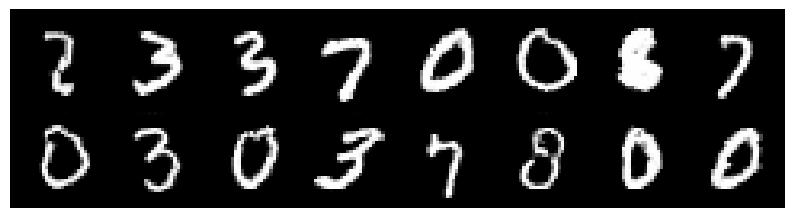

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.96it/s, loss_D=0.361, loss_G=3.09]


Epoch [71/100] - LR G: 0.0003456, LR D: 0.0002000
Epoch [71/100] - Average D loss: 0.6050, Average G loss: 2.2371


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.96it/s, loss_D=0.366, loss_G=1.77]


Epoch [72/100] - LR G: 0.0003456, LR D: 0.0002000
Epoch [72/100] - Average D loss: 0.6059, Average G loss: 2.2405


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.92it/s, loss_D=0.683, loss_G=2.71]

Epoch [73/100] - LR G: 0.0003456, LR D: 0.0002000
Epoch [73/100] - Average D loss: 0.5928, Average G loss: 2.2692


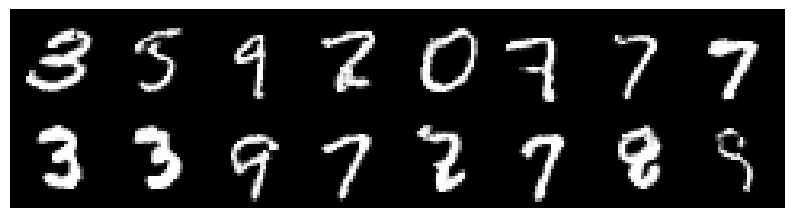

100%|█████████████████████████████████████████████████████| 657/657 [01:36<00:00,  6.80it/s, loss_D=0.543, loss_G=2.72]


Epoch [74/100] - LR G: 0.0003456, LR D: 0.0002000
Epoch [74/100] - Average D loss: 0.5969, Average G loss: 2.2644


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.95it/s, loss_D=0.598, loss_G=3.14]


Epoch [75/100] - LR G: 0.0003456, LR D: 0.0002000
Epoch [75/100] - Average D loss: 0.5904, Average G loss: 2.2667


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.97it/s, loss_D=0.677, loss_G=1.28]

Epoch [76/100] - LR G: 0.0003456, LR D: 0.0002000
Epoch [76/100] - Average D loss: 0.5918, Average G loss: 2.2849


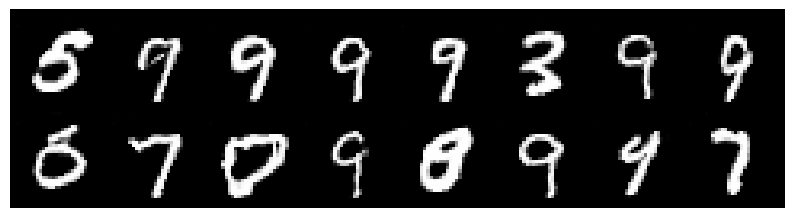

100%|██████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.95it/s, loss_D=0.405, loss_G=2.3]


Epoch [77/100] - LR G: 0.0003456, LR D: 0.0002000
Epoch [77/100] - Average D loss: 0.5841, Average G loss: 2.2971


100%|███████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.96it/s, loss_D=0.35, loss_G=2.7]


Epoch [78/100] - LR G: 0.0003456, LR D: 0.0002000
Epoch [78/100] - Average D loss: 0.5864, Average G loss: 2.2932


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.96it/s, loss_D=0.456, loss_G=2.68]

Epoch [79/100] - LR G: 0.0003456, LR D: 0.0002000
Epoch [79/100] - Average D loss: 0.5891, Average G loss: 2.2823


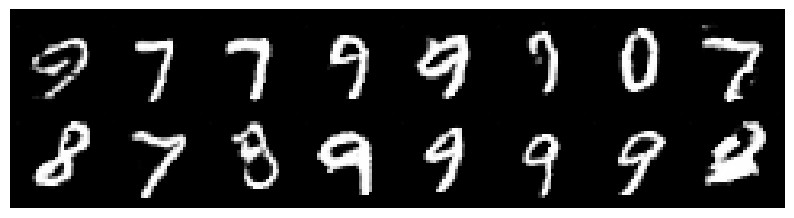

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.96it/s, loss_D=0.382, loss_G=3.23]


Epoch [80/100] - LR G: 0.0004147, LR D: 0.0002000
Epoch [80/100] - Average D loss: 0.5857, Average G loss: 2.2889


100%|██████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.96it/s, loss_D=0.443, loss_G=1.9]


Epoch [81/100] - LR G: 0.0004147, LR D: 0.0002000
Epoch [81/100] - Average D loss: 0.5686, Average G loss: 2.3363


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.96it/s, loss_D=0.306, loss_G=2.82]

Epoch [82/100] - LR G: 0.0004147, LR D: 0.0002000
Epoch [82/100] - Average D loss: 0.5626, Average G loss: 2.4014


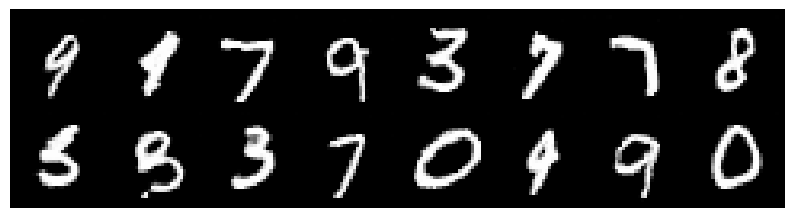

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.782, loss_G=2.42]


Epoch [83/100] - LR G: 0.0004147, LR D: 0.0002000
Epoch [83/100] - Average D loss: 0.5590, Average G loss: 2.3987


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.93it/s, loss_D=0.637, loss_G=1.82]


Epoch [84/100] - LR G: 0.0004147, LR D: 0.0002000
Epoch [84/100] - Average D loss: 0.5623, Average G loss: 2.3739


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.626, loss_G=2.31]

Epoch [85/100] - LR G: 0.0004147, LR D: 0.0002000
Epoch [85/100] - Average D loss: 0.5633, Average G loss: 2.3513


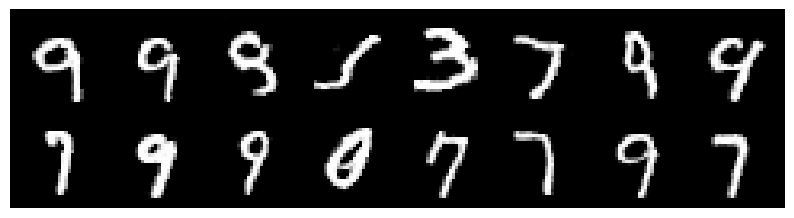

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.95it/s, loss_D=0.588, loss_G=1.99]


Epoch [86/100] - LR G: 0.0004147, LR D: 0.0002000
Epoch [86/100] - Average D loss: 0.5593, Average G loss: 2.3937


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.938, loss_G=2.59]


Epoch [87/100] - LR G: 0.0004147, LR D: 0.0002000
Epoch [87/100] - Average D loss: 0.5691, Average G loss: 2.3388


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.538, loss_G=2.92]

Epoch [88/100] - LR G: 0.0004147, LR D: 0.0002000
Epoch [88/100] - Average D loss: 0.5586, Average G loss: 2.3607


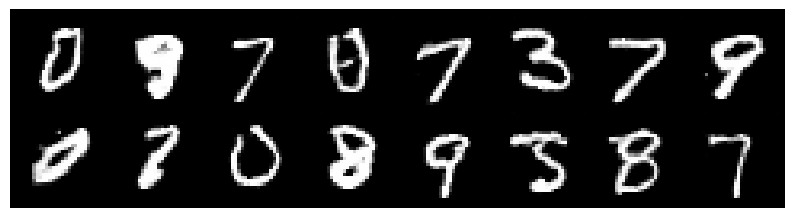

100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.96it/s, loss_D=0.561, loss_G=2.54]


Epoch [89/100] - LR G: 0.0004147, LR D: 0.0002000
Epoch [89/100] - Average D loss: 0.5513, Average G loss: 2.4119


100%|█████████████████████████████████████████████████████| 657/657 [01:34<00:00,  6.94it/s, loss_D=0.675, loss_G=1.91]


Epoch [90/100] - LR G: 0.0004147, LR D: 0.0002000
Epoch [90/100] - Average D loss: 0.5544, Average G loss: 2.3849


100%|█████████████████████████████████████████████████████| 657/657 [01:13<00:00,  8.99it/s, loss_D=0.335, loss_G=2.62]


Epoch [91/100] - LR G: 0.0004147, LR D: 0.0002000
Epoch [91/100] - Average D loss: 0.5542, Average G loss: 2.3872


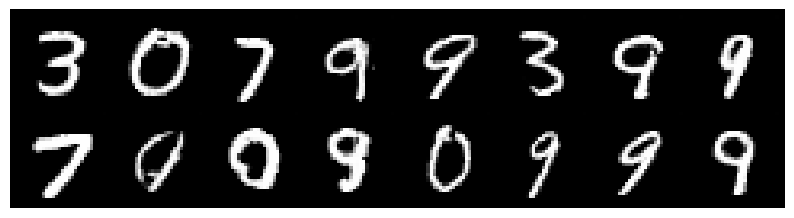

100%|█████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.28it/s, loss_D=0.733, loss_G=2.07]


Epoch [92/100] - LR G: 0.0004147, LR D: 0.0002000
Epoch [92/100] - Average D loss: 0.5514, Average G loss: 2.3896


100%|█████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.30it/s, loss_D=0.714, loss_G=1.62]


Epoch [93/100] - LR G: 0.0004147, LR D: 0.0002000
Epoch [93/100] - Average D loss: 0.5390, Average G loss: 2.4467


100%|█████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.26it/s, loss_D=0.499, loss_G=2.24]


Epoch [94/100] - LR G: 0.0004147, LR D: 0.0002000
Epoch [94/100] - Average D loss: 0.5520, Average G loss: 2.3996


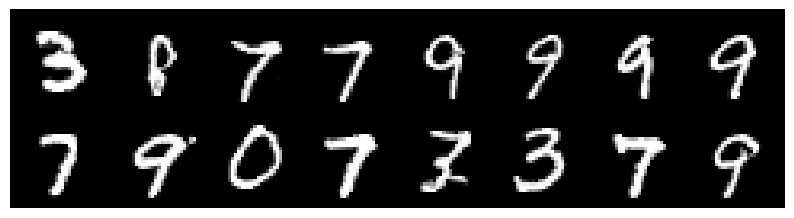

100%|█████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.29it/s, loss_D=0.421, loss_G=2.83]


Epoch [95/100] - LR G: 0.0004147, LR D: 0.0002000
Epoch [95/100] - Average D loss: 0.5414, Average G loss: 2.4296


100%|██████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.29it/s, loss_D=0.31, loss_G=2.97]


Epoch [96/100] - LR G: 0.0004147, LR D: 0.0002000
Epoch [96/100] - Average D loss: 0.5400, Average G loss: 2.4068


100%|██████████████████████████████████████████████████████| 657/657 [01:10<00:00,  9.29it/s, loss_D=0.553, loss_G=2.4]

Epoch [97/100] - LR G: 0.0004147, LR D: 0.0002000
Epoch [97/100] - Average D loss: 0.5426, Average G loss: 2.4350


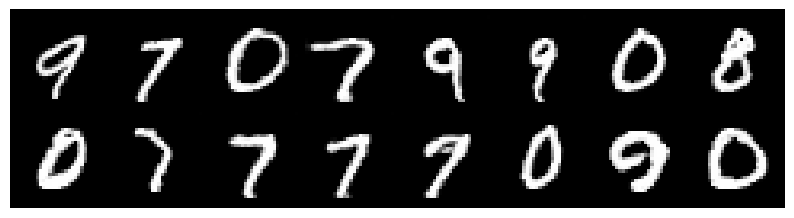

100%|█████████████████████████████████████████████████████| 657/657 [01:03<00:00, 10.41it/s, loss_D=0.449, loss_G=3.31]


Epoch [98/100] - LR G: 0.0004147, LR D: 0.0002000
Epoch [98/100] - Average D loss: 0.5447, Average G loss: 2.4346


100%|█████████████████████████████████████████████████████| 657/657 [00:46<00:00, 14.09it/s, loss_D=0.786, loss_G=2.82]


Epoch [99/100] - LR G: 0.0004147, LR D: 0.0002000
Epoch [99/100] - Average D loss: 0.5419, Average G loss: 2.4339


100%|██████████████████████████████████████████████████████| 657/657 [00:47<00:00, 13.97it/s, loss_D=1.07, loss_G=1.76]


Epoch [100/100] - LR G: 0.0004977, LR D: 0.0002000
Epoch [100/100] - Average D loss: 0.5425, Average G loss: 2.4325


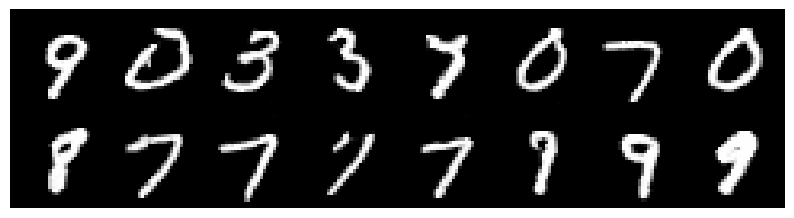

In [13]:
def preprocess_images(images):
    normalized_images = (generated_images + 1) / 2
    display_images = (normalized_images * 255).type(torch.uint8)
    return display_images

# Initialize variables
min_g_loss = float('inf')
epochs = 100
average_d_losses = []  # List to store average discriminator losses per epoch
average_g_losses = []  # List to store average generator losses per epoch

# Assume definitions of loader_discriminator, discriminator, generator, optim_D, and optim_G

for epoch in range(epochs):
    total_d_loss = 0.0
    total_g_loss = 0.0
    count_batches = 0

    loop = tqdm(loader_discriminator, leave=True, total=len(loader_discriminator))
    for real_imgs, _ in loop:
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        optim_D.zero_grad()
        real_preds = discriminator(real_imgs)
        real_loss = F.binary_cross_entropy(real_preds, real_labels)

        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_imgs = generator(noise)
        fake_preds = discriminator(fake_imgs.detach())
        fake_loss = F.binary_cross_entropy(fake_preds, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optim_D.step()

        optim_G.zero_grad()
        tricked_preds = discriminator(fake_imgs)
        g_loss = F.binary_cross_entropy(tricked_preds, real_labels)
        g_loss.backward()
        optim_G.step()

        total_d_loss += d_loss.item()
        total_g_loss += g_loss.item()
        count_batches += 1

        loop.set_postfix(loss_D=d_loss.item(), loss_G=g_loss.item())

    avg_d_loss = total_d_loss / count_batches
    avg_g_loss = total_g_loss / count_batches

    average_d_losses.append(avg_d_loss)
    average_g_losses.append(avg_g_loss)

    scheduler_G.step()
    # scheduler_D.step()

    lr_G = optim_G.param_groups[0]['lr']
    lr_D = optim_D.param_groups[0]['lr']

    # Print current learning rates
    print(f"Epoch [{epoch + 1}/{epochs}] - LR G: {lr_G:.7f}, LR D: {lr_D:.7f}")
    print(f"Epoch [{epoch + 1}/{epochs}] - Average D loss: {avg_d_loss:.4f}, Average G loss: {avg_g_loss:.4f}")

    if epoch % 3 == 0:
        with torch.no_grad():
            test_noise = torch.randn(batch_size, noise_dim).to(device)
            generated_images = generator(test_noise)
            generated_images = preprocess_images(generated_images)

            plt.figure(figsize=(10, 10))
            grid = make_grid(generated_images, nrow=8)
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            plt.axis('off')
            plt.show()

torch.save(generator.state_dict(), 'best_generator.pth')

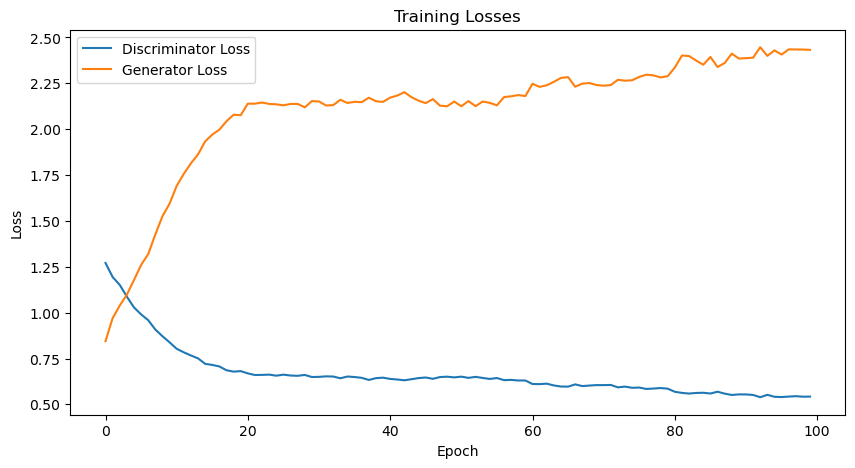

In [14]:
# Plotting the training losses
plt.figure(figsize=(10, 5))
plt.plot(average_d_losses, label='Discriminator Loss')
plt.plot(average_g_losses, label='Generator Loss')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
def calculate_transposed_conv_output_size(H_in, W_in, K, S, P, O):
    """
    Calculate the output dimensions (height and width) of a transposed convolution layer.

    Parameters:
    H_in (int): Height of the input feature map.
    W_in (int): Width of the input feature map.
    K (int): Kernel size.
    S (int): Stride.
    P (int): Padding applied to the input.
    O (int): Output padding.

    Returns:
    tuple: (H_out, W_out) output height and width.
    """
    H_out = (H_in - 1) * S - 2 * P + K + O
    W_out = (W_in - 1) * S - 2 * P + K + O
    return H_out, W_out

# Example usage with specific parameters
H_in, W_in = 26, 26  # Example input dimensions
K = 3             # Kernel size
S = 1              # Stride
P = 0              # Padding
O = 0              # Output padding

# Calculate output dimensions
output_dims = calculate_transposed_conv_output_size(H_in, W_in, K, S, P, O)
output_dims

(28, 28)

In [16]:
def calculate_conv_output_size(input_size, kernel_size, stride, padding):
    """
    Calculate the output size of a convolutional layer.

    Args:
    input_size (tuple): The height and width of the input image (height, width).
    kernel_size (int): The size of the kernel/filter.
    stride (int): The stride of the convolution operation.
    padding (int): The padding added to the input image.

    Returns:
    tuple: The height and width of the output image (height, width).
    """
    input_height, input_width = input_size

    output_height = (input_height + 2 * padding - kernel_size) // stride + 1
    output_width = (input_width + 2 * padding - kernel_size) // stride + 1

    return (output_height, output_width)

# Example usage:
input_height = 28  # Example input height
input_width = 28   # Example input width
kernel_size = 3
stride = 2
padding = 2

output_size = calculate_conv_output_size((input_height, input_width), kernel_size, stride, padding)
print("Output size:", output_size)

Output size: (15, 15)


In [17]:
# Load the trained generator weights
generator.load_state_dict(torch.load('best_generator.pth'))
generator.eval()  # Set to evaluation mode

Generator(
  (fc): Linear(in_features=49, out_features=49, bias=True)
  (convT1): ConvTranspose2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT5): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1))
)

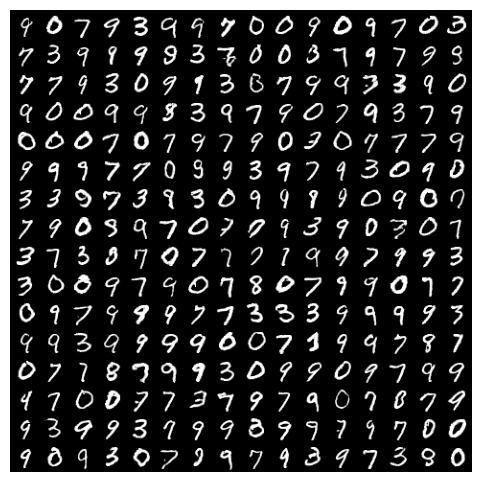

In [18]:
# Generate noise vectors
batch_size = 256  # Number of images to generate
noise = torch.randn(batch_size, noise_dim).to(device)

# Generate images from noise vectors
with torch.no_grad():
    fake_images = generator(noise)

# Assuming images are 28x28 and need to be reshaped
fake_images = fake_images.view(batch_size, 1, 28, 28)  # Reshape images to BxCxHxW format if needed
grid = make_grid(fake_images, nrow=16, normalize=True)  # Create a grid of images

# Visualize images
plt.figure(figsize=(6, 6))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())  # Adjust the channel ordering
plt.axis('off')
plt.show()
